Three-dimensional toy example

The data in this example consists of two classes, one sampled from within a circular tube of radius 1 and the other from a ring tube with inner radius 1 and outer radius 1.41. Both classes have length 4 along the directions of the tubes.

The classes are designed to be informative in the quadratic interactions $x_0x_0$ and $x_1x_1$, but not in the remaining interactions.

In [1]:
import numpy as np

from explainpolysvm import expsvm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

rng = np.random.default_rng(1011)


In [2]:
save_figs = True

In [3]:
n_train_per_class = 500  # We will later remove 25 samples per class to a test set.
def generate_data(n_per_class):
    # Radii for rings
    r_min1 = 0.
    r_max1 = 1.05
    r_min2 = 0.95
    r_max2 = 1.41
    z_min = -2
    z_max = 2

    # Sample from classes
    phi1 = 2 * np.pi * rng.random(size=n_train_per_class)
    r1 = r_min1 + (r_max1 - r_min1) * rng.random(size=(n_train_per_class, 1))
    z1 = z_min + (z_max-z_min) * rng.random(size=(n_train_per_class, 1))
    X1 = np.concatenate((np.multiply(r1, np.transpose(np.array((np.cos(phi1), np.sin(phi1))))),z1),axis=1)

    phi2 = 2 * np.pi * rng.random(size=n_train_per_class)
    r2 = r_min2 + (r_max2 - r_min2) * rng.random(size=(n_train_per_class, 1))
    z2 = z_min + (z_max-z_min) * rng.random(size=(n_train_per_class, 1))
    X2 = np.concatenate((np.multiply(r2, np.transpose(np.array((np.cos(phi2), np.sin(phi2))))),z2),axis=1)
    
    return X1, X2

X_train1, X_train2 = generate_data(n_train_per_class)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


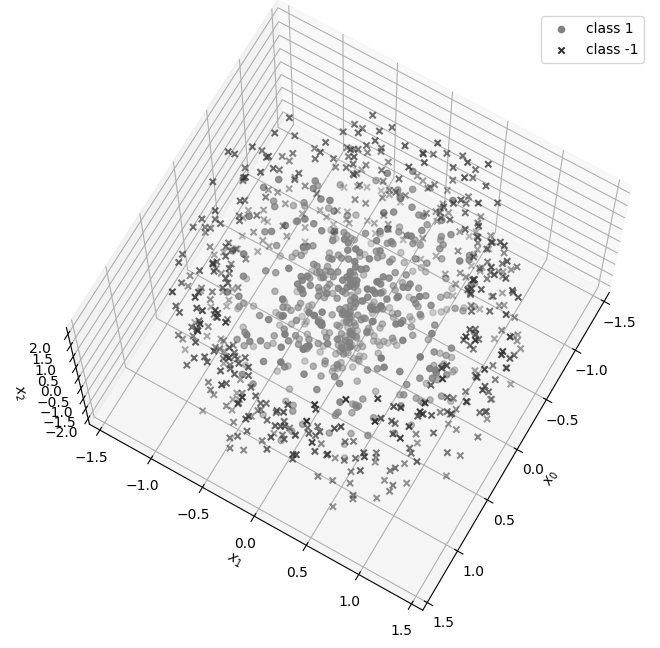

In [4]:
# fig, ax = plt.subplots(1,1, figsize=(5,5))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train1[:,0], X_train1[:,1], X_train1[:,2], color=[0.5, 0.5, 0.5])
ax.scatter(X_train2[:,0], X_train2[:,1], X_train2[:,2], color=[0.2, 0.2, 0.2], marker='x')
# ax.set_aspect('equal', adjustable='box')
plt.legend(['class 1', 'class -1'])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
ax.view_init(70,30)

if save_figs:
    plt.savefig('./images/training_data_3d.png', dpi=200, facecolor='white', bbox_inches='tight')
    plt.savefig('./images/training_data_3d.eps', facecolor='white', bbox_inches='tight')
plt.draw()

Fit Scikit-learn SVC model using a quadratic polynomial kernel and manually set hyperparameters.

In [5]:
X = np.concatenate((X_train1, X_train2), axis=0)
y = np.concatenate((np.ones(n_train_per_class), -np.ones(n_train_per_class)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=600, random_state=10)
# Fit SVM
C = 0.9
degree = 3
gamma = 'scale'
r = np.sqrt(2)

# Fit SVM
kernel = 'poly'
model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=r)
model.fit(X_train, y_train)

sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                kernel_d=degree, kernel_r=r, kernel_gamma=kernel_gamma)
es.transform_svm()

Test performance

In [6]:
y_pred = np.sign(es.decision_function(x=X_test))
acc = np.sum(y_pred==y_test)/y_test.size
print('Test accuracy: {}'.format(acc))

Test accuracy: 0.9183333333333333


Feature importance

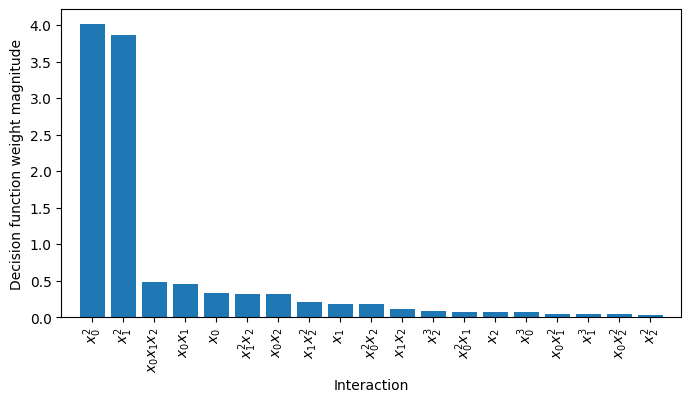

In [7]:
fig = es.plot_model_bar(n_features=20, magnitude=True, figsize=(8,4), show=False)
fig.gca().set_title('')
if save_figs:
    plt.savefig('./images/feature_importance_3d.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_3d.eps', bbox_inches='tight', facecolor='white')
plt.show()

The two expected interactions, $x_0x_0$ and $x_1x_1$, clearly stands out as the two most important.

Evaluate performance using the top-2 features

In [8]:
es.set_mask(n_interactions=2)
# es.force_mask=True
y_pred_masked = np.sign(es.decision_function(x=X_test, mask=True))
acc_masked = np.sum(y_pred_masked==y_test)/y_test.size
print('Test accuracy using top-2 interactions: {}'.format(acc_masked))

Test accuracy using top-2 interactions: 0.9466666666666667


Plot signed importance

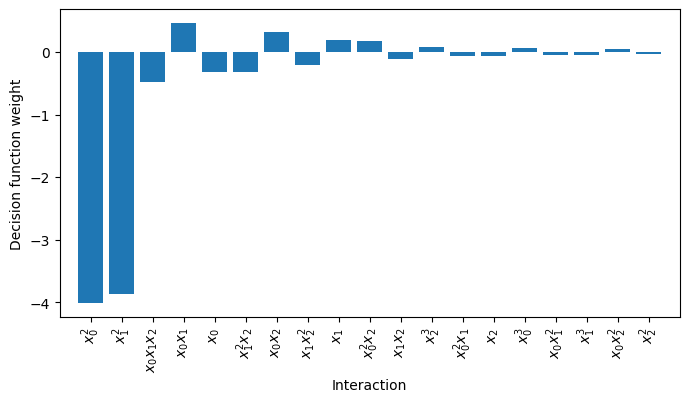

In [9]:
fig = es.plot_model_bar(n_features=20, magnitude=False, figsize=(8,4), show=False)
fig.gca().set_title('')
if save_figs:
    plt.savefig('./images/feature_importance_signed_3d.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_signed_3d.eps', bbox_inches='tight', facecolor='white')
plt.show()

Investigate decision function components for a single observation

Features:  [ 0.35562134 -1.35224797  0.59212626]
Radial distance to x_2 axis:  1.3982278464873796
True class label:  -1.0
Decision value:  -4.591352851114159
SVM intercept:  3.4550476291157173


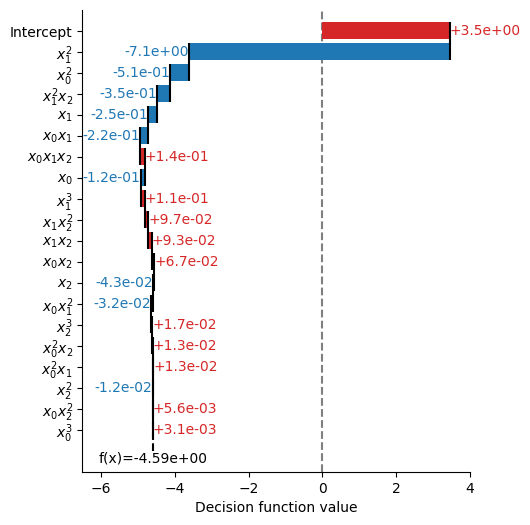

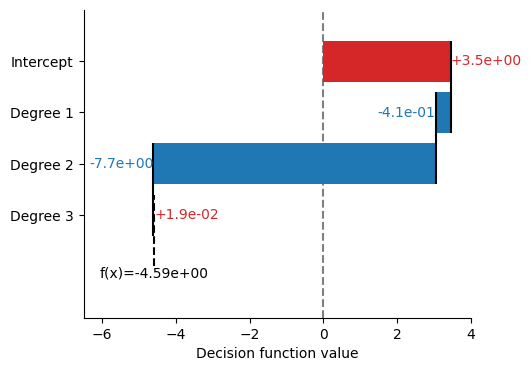

In [10]:
x = X_test[0,:]

# Print information about the sample and it's decision
y_comp = es.decision_function_components(x=x, output_interaction_names=False)
y_comp = y_comp[0]
print('Features: ', x)
print('Radial distance to x_2 axis: ', np.sqrt(x[0]**2+x[1]**2))
print('True class label: ', y_test[0])
print('Decision value: ', np.sum(y_comp))
print('SVM intercept: ', es.intercept)

# Plot waterfall of individual interaction's contribution
_ = es.plot_sample_waterfall(x, n_features=19, show=False, show_values=True, show_sum=True, figsize=(5,6), xlim=[-6.5, 4])
if save_figs:
    plt.savefig('./images/feature_importance_single_3d.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_importance_single_3d.eps', bbox_inches='tight', facecolor='white')
plt.show()

# Plot waterfall of the interaction degree's contribution
_ = es.plot_sample_waterfall_degree(x, n_degree=3, show=False, show_values=True, show_sum=True, figsize=(5,4), xlim=[-6.5, 4])
if save_figs:
    plt.savefig('./images/degree_importance_single_3d.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/degree_importance_single_3d.eps', bbox_inches='tight', facecolor='white')
plt.show()



Apply feature selection by masking

In [11]:
n_interactions = len(es.get_interactions())
n_test_per_class = 500
n_test_sets = 100
accs = np.zeros((n_test_sets,n_interactions))
for test_ind in np.arange(n_test_sets):
    x_test_tmp1, x_test_tmp2 = generate_data(n_test_per_class)
    
    X_test_tmp = np.concatenate((x_test_tmp1, x_test_tmp2), axis=0)
    y_test_tmp = np.concatenate((np.ones(n_test_per_class), -np.ones(n_test_per_class)))
    
    for n_remove in np.arange(n_interactions):
        es.set_mask(n_interactions=n_interactions-n_remove)

        y_pred_tmp = np.sign(es.decision_function(x=X_test_tmp, mask=True))
        accs[test_ind, n_remove] = np.sum(y_pred_tmp==y_test_tmp)/y_test_tmp.size

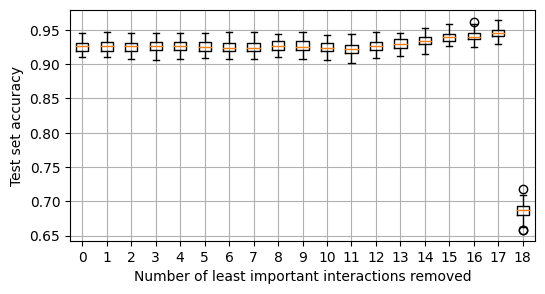

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
plt.boxplot(x=accs, positions=np.arange(n_interactions))
plt.xlabel('Number of least important interactions removed')
plt.ylabel('Test set accuracy')
plt.grid()
if save_figs:
    plt.savefig('./images/feature_selection_3d.png', dpi=200, bbox_inches='tight', facecolor='white')
    plt.savefig('./images/feature_selection_3d.eps', bbox_inches='tight', facecolor='white')
plt.show()

We find that removing interactions that are not $x_0^2$ or $x_1^2$ improves decisions, but removing one of them drastically decrease performance. There also seem to be a small decrease in the spread in the distribution when removing interactions.
